# Deconvolution of electrochemical impedance spectroscopy data using the deep-neural-network-enhanced distribution of relaxation times

In this tutorial, we will show how two use the DNN-DRT model to analyze the synthetic EIS data generated with the "hook" model (Section 3.1.4).

In [1]:
# import the librairies needed
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cvxpy as cp
import sys
from torch import nn
import math
from math import pi, sin, cos, sqrt, log
import compute_DRT

In [2]:
# check the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**2,3), 'MB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**2,3), 'MB')
    
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Using device: cpu


In [3]:
# seed the random number generator
np.random.seed(21312)
torch.manual_seed(213912);
os.environ['PYTHONHASHSEED']=str(213912)

In [4]:
# plot standards
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# 1. Generate the synthetic data

## 1.1 Define the ranges of frequencies and timescales

In [5]:
# define frequency range
log_freq_min = -2.
log_freq_max = 6.
N_f = 10*int(log_freq_max-log_freq_min)+1
freq_vec = np.logspace(log_freq_min, log_freq_max, num=N_f, endpoint=True).reshape(N_f,1)

# define tau range (as in previous papers tau=1/f)
log_tau_min = -log_freq_max
log_tau_max = -log_freq_min

# tau's for ridge regression
N_tau_RR = 10*int(log_tau_max-log_tau_min)+1
tau_vec_RR = np.logspace(log_tau_min, log_tau_max, num = N_tau_RR, endpoint=True).reshape(N_tau_RR,1)
log_tau_vec_RR = np.log(tau_vec_RR)
# during pretraining the ANN will take the normalized log of the tau_RR vector as input
# for consistency with the NN implementation we will compute the L1 matrix using the following
# normalized log(tau) vector
log_tau_vec_RR_norm = -1.+2.*(log_tau_vec_RR-log_tau_vec_RR.min())/(log_tau_vec_RR.max()-log_tau_vec_RR.min())

# the NN will use a much more finer grid, consistent with differential programming so the tau's of the NN, are far more
N_tau_NN = 10*int(log_tau_max-log_tau_min)+1
tau_vec_NN = np.logspace(log_tau_min, log_tau_max, num = N_tau_NN, endpoint=True).reshape(N_tau_NN,1)
log_tau_vec_NN = np.log(tau_vec_NN)
# the ANN will take the normalized log10 of the tau vector as input
log_tau_vec_NN_norm = -1.+2.*(log_tau_vec_NN-log_tau_vec_NN.min())/(log_tau_vec_NN.max()-log_tau_vec_NN.min())

## 1.2 Define the circuit parameters

In [6]:
R_inf = 10.
sigma_n = 0.5

# ZARC 1
R_ct_1 = 50.
phi_1 = 0.9
tau_1 = 1E-4

# ZARC 2
R_ct_2 = -10. # this enforces the hook
phi_2 = 0.9
tau_2 = 1E-1

## 1.3 Define the exact and experimental impedances (see Table 2 in [Link](https://doi.org/10.1016/j.electacta.2022.141499))

In [7]:
# exact impedance
T_1 = tau_1**phi_1/R_ct_1
T_2 = tau_2**phi_2/R_ct_2

Z_exact = R_inf + 1./(1./R_ct_1+T_1*(1j*2.*pi*freq_vec)**phi_1) + 1./(1./R_ct_2+T_2*(1j*2.*pi*freq_vec)**phi_2)

# experimental impedance spectrum
Z_exp = Z_exact+sigma_n*(np.random.normal(0, 1, Z_exact.shape)+1j*np.random.normal(0, 1, Z_exact.shape))

## 1.4 Define the exact DRT (see Table 2 in [Link](https://doi.org/10.1016/j.electacta.2022.141499))

In [9]:
# first DRT
gamma_exact_RR_1 = (R_ct_1)/(2.*pi)*sin((1.-phi_1)*pi)/(np.cosh(phi_1*np.log(tau_vec_RR/tau_1))-cos((1.-phi_1)*pi))
gamma_exact_NN_1 = (R_ct_1)/(2.*pi)*sin((1.-phi_1)*pi)/(np.cosh(phi_1*np.log(tau_vec_NN/tau_1))-cos((1.-phi_1)*pi))
# second DRT
gamma_exact_RR_2 = (R_ct_2)/(2.*pi)*sin((1.-phi_2)*pi)/(np.cosh(phi_2*np.log(tau_vec_RR/tau_2))-cos((1.-phi_2)*pi))
gamma_exact_NN_2 = (R_ct_2)/(2.*pi)*sin((1.-phi_2)*pi)/(np.cosh(phi_2*np.log(tau_vec_NN/tau_2))-cos((1.-phi_2)*pi))
# total gamma
gamma_exact_RR = gamma_exact_RR_1 + gamma_exact_RR_2
gamma_exact_NN = gamma_exact_NN_1 + gamma_exact_NN_2

# normalized gamma
R_ct = R_ct_1 + R_ct_2
gamma_exact_RR_norm = gamma_exact_RR/R_ct
gamma_exact_NN_norm = gamma_exact_NN/R_ct

## 1.5 Nyquist plot of the experimental and exact impedances

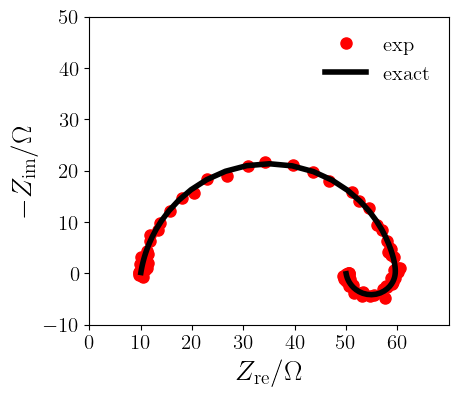

In [10]:
plt.plot(np.real(Z_exp), -np.imag(Z_exp), 'o', markersize=8, color='red', label='exp')
plt.plot(np.real(Z_exact), -np.imag(Z_exact), linewidth=4, color='black', label='exact')

plt.axis([0,70,-10,50])
plt.xticks(np.arange(0, 70, step=10))
plt.legend(frameon=False, fontsize = 15)
plt.gca().set_aspect('equal', adjustable='box')
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
fig = plt.gcf()
fig.set_size_inches(6.472, 4)
plt.show()

# 2. Ridge regression (RR) to prepare the pretraining step

## 2.1 Conduct RR

In [11]:
# data
Z_RR = np.zeros(2*N_f)
Z_RR[:N_f] = Z_exp.real.flatten()
Z_RR[N_f:] = Z_exp.imag.flatten()

# matrices
A_re_RR = compute_DRT.compute_A_re(freq_vec, tau_vec_RR)
A_im_RR = compute_DRT.compute_A_im(freq_vec, tau_vec_RR)
L2_RR = compute_DRT.compute_L2(log_tau_vec_RR_norm)
L1_RR = compute_DRT.compute_L1(log_tau_vec_RR_norm)

# build matrices for cvxpy
lambda_0 = 1.0E-5 
A_R0 = np.zeros((2*N_f,1))
A_R0[0:N_f,0] = 1.0
A_RR = np.hstack( ( A_R0, np.vstack((A_re_RR, A_im_RR)) ) )
L1_RR = np.hstack( ( np.zeros((N_tau_RR-1,1)), L1_RR ) )
Q = A_RR.T@A_RR + lambda_0*L1_RR.T@L1_RR 
q = -2.*A_RR.T@Z_RR

# Define and solve the CVXPY problem.
x_RR = cp.Variable(N_tau_RR+1)
prob = cp.Problem(cp.Minimize(cp.quad_form(x_RR, Q) + q.T @ x_RR)) # , [x_RR >= 0]) # we do not need a positive gamma anymore 
prob.solve();

## 2.2 Plot of the DRT recovered with RR

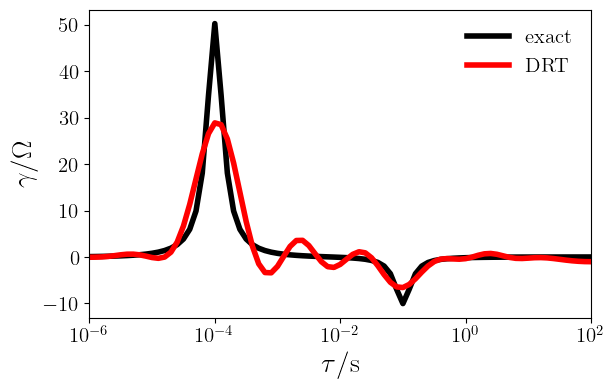

In [12]:
plt.semilogx(tau_vec_RR, gamma_exact_RR, linewidth=4, color='black', label= 'exact')
plt.semilogx(tau_vec_RR, x_RR.value[1:], linewidth=4, color='red', label='DRT')

plt.xlim(1E-6, 1E2)
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$\tau/\rm s$', fontsize=20)
plt.ylabel(r'$\gamma/\Omega$', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(6.472, 4)
plt.show()

## 2.3 Recover the impedance with the DRT obtained from RR

In [13]:
gamma_0 = x_RR.value[1:]
Z_re_pretrain = x_RR.value[0] + A_re_RR@gamma_0
Z_im_pretrain = A_im_RR@gamma_0
Z_pretrain = Z_re_pretrain + 1j*Z_im_pretrain

## 2.4 Nyquist plot of the experimental, exact, and RR-recovered impedances

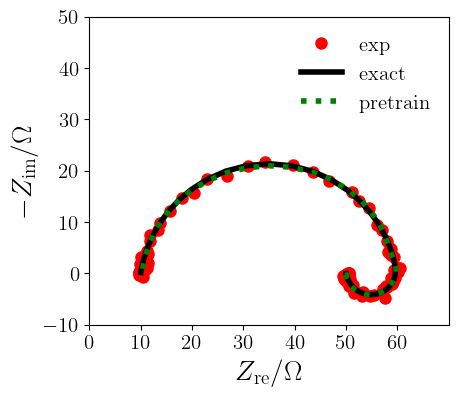

In [14]:
plt.plot(np.real(Z_exp), -np.imag(Z_exp), 'o', markersize=8, color='red', label='exp')
plt.plot(np.real(Z_exact), -np.imag(Z_exact), linewidth=4, color='black', label='exact')
plt.plot(np.real(Z_pretrain), -np.imag(Z_pretrain), linestyle=':', linewidth=4, color='green', label='pretrain')
plt.axis([0,70,-10,50])
plt.xticks(np.arange(0, 70, step=10))
plt.legend(frameon=False, fontsize = 15)
plt.gca().set_aspect('equal', adjustable='box')
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
fig = plt.gcf()
fig.set_size_inches(6.472, 4)
plt.show()

# 3. Normalization 

In [15]:
# First normalize the Zexp based on RR
R_inf_RR = x_RR.value[0]
R_ct_RR = np.trapz(x_RR.value[1:], log_tau_vec_RR.flatten())
Z_exp_norm = (Z_exp-R_inf_RR)/R_ct_RR

# Then normalize the gamma the obtained gamma's
gamma_RR = x_RR.value[1:].reshape(N_tau_RR,1)
gamma_RR_norm = gamma_RR/R_ct_RR

# 4. Pretraining of the deep neural network (DNN)

## 4.1 Prepare the vectors

In [16]:
# gamma from RR and its normalization
gamma_RR_torch =  torch.from_numpy(gamma_RR).type(Tensor)
gamma_RR_norm_torch =  torch.from_numpy(gamma_RR_norm).type(Tensor)

# gamma exact for the NN (we will used it to compute the distances)
gamma_exact_NN_torch = torch.from_numpy(gamma_exact_NN).type(Tensor)

# torch vectors 

# log(tau) used for pretraining and full training
log_tau_vec_RR_norm_torch = torch.from_numpy(log_tau_vec_RR_norm).type(Tensor)
log_tau_vec_NN_norm_torch = torch.from_numpy(log_tau_vec_NN_norm).type(Tensor)

# log(tau) used for the integration error computation
log_tau_vec_NN_torch = torch.from_numpy(log_tau_vec_NN).type(Tensor)

# Z_exp used for inversion
Z_exp_re_norm_torch = torch.from_numpy(np.real(Z_exp_norm)).type(Tensor)
Z_exp_im_norm_torch = torch.from_numpy(np.imag(Z_exp_norm)).type(Tensor)

## 4.2 Define the DNN (see Section 2.5.4 in [Link](https://doi.org/10.1016/j.electacta.2022.141499))

In [17]:
class gamma_elu_layer(nn.Module):

    def __init__(self, in_features, out_features):
        
        super().__init__()
        
        self.linear = nn.Linear(in_features, out_features, bias=True)        
        nn.init.xavier_uniform_(self.linear.weight)
        nn.init.uniform_(self.linear.bias)

    def forward(self, input):
        return F.elu(self.linear(input))
    
class gamma_sine_layer(nn.Module):

    def __init__(self, in_features, out_features):
        
        super().__init__()
        
        self.linear = nn.Linear(in_features, out_features, bias=True)        
        nn.init.xavier_normal_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)

    def forward(self, input):
        return torch.sin(self.linear(input))
    
class gamma_softplus_layer(nn.Module):

    def __init__(self, in_features, out_features):
        
        super().__init__()
        
        self.linear = nn.Linear(in_features, out_features, bias=True)        
        nn.init.xavier_normal_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)

    def forward(self, input):
        return F.softplus(self.linear(input))
    
    
class gamma_net(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features):
        super().__init__()
        
        self.net = []
        self.net.append(gamma_sine_layer(in_features, hidden_features))
        
        for i in range(hidden_layers):
            self.net.append(gamma_elu_layer(hidden_features, hidden_features))

        # self.net.append(gamma_softplus_layer(hidden_features, out_features)) cannot be used because it enforces positivity
        self.net.append(gamma_elu_layer(hidden_features, out_features))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords
    
# Define the model from the gamma_net class
model_gamma = gamma_net(in_features=1, out_features=1, hidden_features=32, hidden_layers=10)

if cuda:
    model_gamma.cuda()
print(compute_DRT.count_parameters(model_gamma))

10657


## 4.3 Pretraining step (see Section 2.5.2 in [Link](https://doi.org/10.1016/j.electacta.2022.141499))

In [18]:
# Let us first pretrain the model against the RR with the following loss
def loss_pretrain_fn(x, gamma):
    MSE = torch.sum((x - gamma)**2)    
    return MSE

# With the following parameters
    
learning_rate = 1e-3
max_iters = 2001
optimizer = torch.optim.Adam(model_gamma.parameters(), lr=learning_rate)#, weight_decay=1E-5)

# To compute the pre-training loss, we need to port some numpy vectors to pytorch, for now we limit ourselves to two (we will have more later)

# Let us now pretrain the model

# numpy arrays where solved data will be saved
loss_pretrain_store = np.array([])
gamma_NN_pretrain_store = np.zeros((N_tau_RR, max_iters+1))

# pretrain torch
gamma_NN_pretrain_torch, coords = model_gamma(log_tau_vec_RR_norm_torch)
loss_pretrain = loss_pretrain_fn(gamma_NN_pretrain_torch, gamma_RR_norm_torch)

# store gamma from NN
gamma_NN_pretrain_store[:, 0] = gamma_NN_pretrain_torch.detach().cpu().numpy().flatten()
# loss and store first value
loss_pretrain_store = np.append(loss_pretrain_store, loss_pretrain.item())

for t in range(max_iters):

    # Forward pass: compute predicted y by passing x to the model.
    gamma_NN_pretrain_torch, coords = model_gamma(log_tau_vec_RR_norm_torch)
    
    # Compute the loss
    loss = loss_pretrain_fn(gamma_NN_pretrain_torch, gamma_RR_norm_torch)
    
    # set grads to zero
    optimizer.zero_grad()

    # backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # the step function of the Optimizer updates the NN parameters
    optimizer.step()
    
    # save loss
    loss_pretrain_store = np.append(loss_pretrain_store, loss.item())
    
    # store gamma
    gamma_NN_pretrain_store[:, t+1] = gamma_NN_pretrain_torch.detach().cpu().numpy().flatten()
    
    # and print it
    if not t%200:
        print('iter=%d; loss=%e' % (t, loss.item()))

iter=0; loss=1.514880e+01
iter=200; loss=2.948517e-01
iter=400; loss=1.003111e-01
iter=600; loss=1.370064e-01
iter=800; loss=6.384017e-02
iter=1000; loss=5.918062e-02
iter=1200; loss=5.367376e-02
iter=1400; loss=5.729313e-02
iter=1600; loss=3.343758e-02
iter=1800; loss=6.915269e-03
iter=2000; loss=2.464297e-03


## 4.4 Plot of the exact, RR-recovered, and DNN-pretrained DRTs

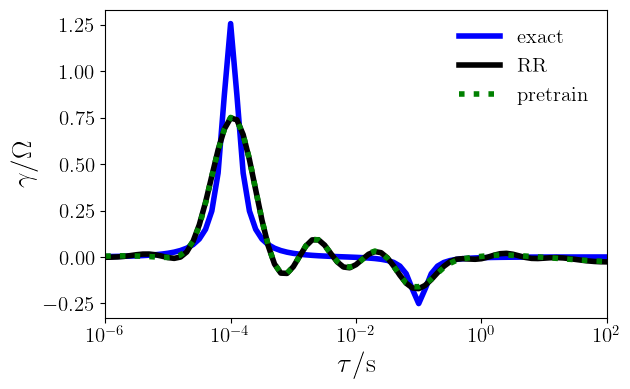

In [21]:
plt.semilogx(tau_vec_RR, gamma_exact_RR_norm, linewidth=4, color='blue', label= 'exact')
plt.semilogx(tau_vec_RR, gamma_RR_norm, linewidth=4, color='black', label='RR') 
plt.semilogx(tau_vec_RR, gamma_NN_pretrain_torch.detach().cpu().numpy().flatten(), linestyle=':',linewidth=4,color='green', label='pretrain') 

plt.xlim(1E-6, 1E2)
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$\tau/\rm s$', fontsize=20)
plt.ylabel(r'$\gamma/\Omega$', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(6.472, 4)
plt.show()

## 4.5 Recover the impedance with the DRT outputted by the pretained DNN

In [22]:
gamma_0 = gamma_NN_pretrain_store[:,-1]*R_ct_RR
Z_re_pretrain = x_RR.value[0] + A_re_RR@gamma_0
Z_im_pretrain = A_im_RR@gamma_0
Z_pretrain = Z_re_pretrain + 1j*Z_im_pretrain

## 4.6 Nyquist plot of the experimental, exact, and DNN-pretrained impedances

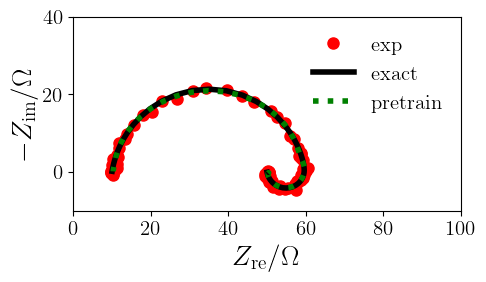

In [23]:
plt.plot(np.real(Z_exp), -np.imag(Z_exp), 'o', markersize=8, color='red', label='exp')
plt.plot(np.real(Z_exact), -np.imag(Z_exact), linewidth=4, color='black', label='exact')
plt.plot(np.real(Z_pretrain), -np.imag(Z_pretrain), linestyle=':', linewidth=4, color='green', label='pretrain')

plt.axis([0,100,-10,40])
# plt.xticks(np.arange(0, 100, step=20))
plt.legend(frameon=False, fontsize = 15)
plt.gca().set_aspect('equal', adjustable='box')
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
fig = plt.gcf()
fig.set_size_inches(5, 4)
plt.show()

# 5. Training of the DNN

## 5.1 Preprare the training and define the training loss given in (9 [Link](https://doi.org/10.1016/j.electacta.2022.141499))

In [24]:
# data used in NN is transformed to a pytorch tensor
A_re = compute_DRT.compute_A_re(freq_vec, tau_vec_NN)
A_im = compute_DRT.compute_A_im(freq_vec, tau_vec_NN)

A_re_torch = torch.from_numpy(A_re).type(Tensor)
A_im_torch = torch.from_numpy(A_im).type(Tensor)

def first_derivative(y, x):
    grad_outputs = torch.ones_like(y)
    first_derivative_out = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return first_derivative_out

def second_derivative(y, x):
    first_derivative_out = first_derivative(y, x)    
    second_derivative_out = first_derivative(first_derivative_out, x)    
    return second_derivative_out

Delta_log_tau = abs(log_tau_vec_NN_norm[2]-log_tau_vec_NN_norm[1]).item()
beta = 0.5
alpha = beta*Delta_log_tau
print(alpha)

def loss_fn(R_inf, gamma, log_tau_norm, A_re, A_im, lambda_0, alpha, Z_re, Z_im):
    
    MSE = 0.0     
    MSE_re = torch.sum((R_inf + torch.matmul(A_re,gamma) - Z_re)**2)
    MSE_im = torch.sum((torch.matmul(A_im,gamma) - Z_im)**2)
    
    MSE_D1 = torch.sum(1/alpha*torch.clamp(-gamma[1:]*gamma[:-1], 0, alpha) )
    MSE_D2 = torch.sum(2/alpha*torch.clamp(-gamma[2:]*gamma[:-2], 0, alpha/2) )
    MSE_D = MSE_D1 + MSE_D2
    
    grad = first_derivative(gamma, log_tau_norm).flatten()
    zeta = 1/(4*(lambda_0**2))
    lambda_delP = 1/zeta*(torch.sqrt(grad.detach()**4+2*zeta)-grad.detach()**2)
    MSE_der = torch.trapz(lambda_delP*grad**2,log_tau_norm.detach().flatten())
        
    MSE = MSE + MSE_re + MSE_im + MSE_D + MSE_der 
    return MSE

print(compute_DRT.count_parameters(model_gamma))

# saving the model for earlystop, min loss, and optimal
check_Early_stop = 0
t_min_loss_loop = 0
distance_opt = np.inf

learning_rate = 1e-4
max_iters = 20001

optimizer = torch.optim.Adam(model_gamma.parameters(), lr=learning_rate)#, weight_decay=1E-5)

R_inf_torch = torch.tensor([0.0], requires_grad=True, device="cpu").type(Tensor)
optimizer.add_param_group({'params': R_inf_torch})
print(compute_DRT.count_parameters(model_gamma))

# we will store key neural network results here
loss_store = np.array([])
distance_store = np.array([])
gamma_NN_store = torch.zeros((N_tau_NN,max_iters+1)).type(Tensor)
R_inf_store = torch.zeros(max_iters+1).type(Tensor)

# the gamma is stored here
gamma_NN_norm, coords = model_gamma(log_tau_vec_NN_norm_torch)
gamma_NN_store[:, 0] = gamma_NN_norm.detach().flatten()
    
loss = loss_fn(R_inf_torch, gamma_NN_norm, coords, A_re_torch, A_im_torch, lambda_0, alpha, Z_exp_re_norm_torch, Z_exp_im_norm_torch)

loss_store = np.append(loss_store, loss.item())
R_inf_store[0] = R_inf_RR + R_ct_RR*R_inf_torch[0].detach().item()

squared_distance = torch.trapz((R_ct_RR*gamma_NN_norm.detach().T-gamma_exact_NN_torch.T)**2,log_tau_vec_NN_norm_torch.T)
distance_store = np.append(distance_store, sqrt(squared_distance.item()))

0.012500000000000011
10657
10657


## 5.2 Training step (see Section 2.5.3 in [Link](https://doi.org/10.1016/j.electacta.2022.141499))

In [22]:
for t in range(max_iters):

    # Forward pass: compute predicted y by passing x to the model.
    gamma_NN, coords = model_gamma(log_tau_vec_NN_norm_torch)

    # Compute the loss
    loss = loss_fn(R_inf_torch, gamma_NN, coords, A_re_torch, A_im_torch, lambda_0, alpha, Z_exp_re_norm_torch, Z_exp_im_norm_torch)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # save loss
    loss_store = np.append(loss_store, loss.item())
    if check_Early_stop ==0:
        if(len(loss_store)>1):
            # check for early stop iteration
            if (np.abs(loss_store[t]-loss_store[t-1]))<1E-10:
                torch.save(model_gamma.state_dict(), './results/model_gamma_EStop.pth')
                iter_Early_Stop = t # to get the same iter as main.plot iter
                check_Early_stop = 1
                    
    # store gamma
    gamma_NN_store[:, t+1] = R_ct_RR*gamma_NN.detach().flatten()
    
    # save distance
    squared_distance = torch.trapz((R_ct_RR*gamma_NN.detach().T-gamma_exact_NN_torch.T)**2,log_tau_vec_NN_norm_torch.T)
    distance_store = np.append(distance_store, sqrt(squared_distance.item()))
    
    # save of the optimal model
    distance_loc = sqrt(squared_distance)
    if distance_loc<distance_opt:
        torch.save(model_gamma.state_dict(), './results/model_gamma_opt.pth')
        Iter_Opt = t+1
        distance_opt = distance_loc
    
    # store R_inf
    R_inf_store[t+1] = R_inf_RR + R_ct_RR*R_inf_torch[0].detach().item()

    # and print it
    if not t%200:
        print('iter=%d; loss=%e' % (t, loss.item()))
        
gamma_0 = gamma_NN_pretrain_store[:,-1]*R_ct_RR
Z_re_pretrain = x_RR.value[0] + A_re_RR@gamma_0
Z_im_pretrain = A_im_RR@gamma_0
Z_pretrain = Z_re_pretrain + 1j*Z_im_pretrain

iter_opt = np.argmin(distance_store)
iter_min_loss = np.argmin(loss_store)
iter_early_stop = np.flatnonzero(np.abs(np.diff(loss_store))<1E-8)
iter_guess = 2000

gamma_early_stop = gamma_NN_store[:,iter_early_stop[1]]
gamma_opt = gamma_NN_store[:,iter_opt]
gamma_min_loss = gamma_NN_store[:,iter_min_loss]
gamma_guess = gamma_NN_store[:,iter_guess]

Z_re_early_stop = R_inf_store[iter_early_stop[1]] + torch.matmul(A_re_torch,gamma_early_stop)
Z_im_early_stop = torch.matmul(A_im_torch,gamma_early_stop)
Z_early_stop = Z_re_early_stop.cpu().numpy()+ 1j*Z_im_early_stop.cpu().numpy()

Z_re_opt = R_inf_store[iter_opt] + torch.matmul(A_re_torch,gamma_opt)
Z_im_opt = torch.matmul(A_im_torch,gamma_opt)
Z_opt = Z_re_opt.cpu().numpy()+ 1j*Z_im_opt.cpu().numpy()

Z_re_min_loss = R_inf_store[iter_min_loss] + torch.matmul(A_re_torch,gamma_min_loss)
Z_im_min_loss = torch.matmul(A_im_torch,gamma_min_loss)
Z_min_loss = Z_re_min_loss.cpu().numpy()+ 1j*Z_im_min_loss.cpu().numpy()

Z_re_guess = R_inf_store[iter_min_loss] + torch.matmul(A_re_torch,gamma_guess)
Z_im_guess = torch.matmul(A_im_torch,gamma_guess)
Z_guess = Z_re_guess.cpu().numpy()+ 1j*Z_im_guess.cpu().numpy()

iter=0; loss=3.452690e+00
iter=200; loss=1.665039e+00
iter=400; loss=8.042604e-02
iter=600; loss=4.398366e-02
iter=800; loss=4.790155e-02
iter=1000; loss=4.285500e-02
iter=1200; loss=3.393151e-02
iter=1400; loss=4.290122e-02
iter=1600; loss=3.299243e-02
iter=1800; loss=3.527259e-02
iter=2000; loss=2.849651e-02
iter=2200; loss=6.113912e-02
iter=2400; loss=2.820353e-02
iter=2600; loss=3.395237e-02
iter=2800; loss=2.606017e-02
iter=3000; loss=2.581480e-02
iter=3200; loss=2.646800e-02
iter=3400; loss=2.820117e-02
iter=3600; loss=2.658830e-02
iter=3800; loss=2.598836e-02
iter=4000; loss=3.546007e-02
iter=4200; loss=1.112843e-01
iter=4400; loss=2.523515e-02
iter=4600; loss=2.509240e-02
iter=4800; loss=4.745885e-02
iter=5000; loss=2.628486e-02
iter=5200; loss=3.233264e-02
iter=5400; loss=2.457407e-02
iter=5600; loss=2.771097e-02
iter=5800; loss=2.611205e-02
iter=6000; loss=3.248700e-02
iter=6200; loss=2.727965e-02
iter=6400; loss=4.645658e-02
iter=6600; loss=2.945559e-02
iter=6800; loss=2.580

In [ ]:
##

## 5.3 Plot of the exact, DNN-pretrained, and DNN-trained DRTs (Figure 7 (a) in [Link](https://doi.org/10.1016/j.electacta.2022.141499))

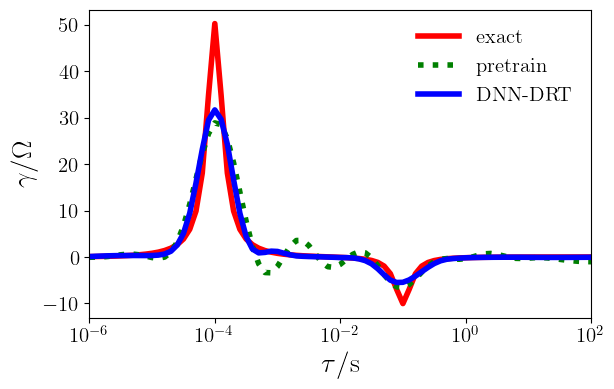

In [36]:
plt.semilogx(tau_vec_RR, gamma_exact_RR.flatten(), linewidth=4, color='red', label= 'exact')
plt.semilogx(tau_vec_RR, x_RR.value[1:], linestyle=':',linewidth=4, color='green', label='pretrain') 
plt.semilogx(tau_vec_NN, gamma_opt.cpu().flatten(), '-', linewidth=4, color='blue', label='DNN-DRT') 

plt.xlim(1E-6, 1E2)
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$\tau/\rm s$', fontsize=20)
plt.ylabel(r'$\gamma/\Omega$', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(6.472, 4)
plt.show()

## 5.4 Nyquist plot of the experimental, exact, DNN-pretrained, and DNN-trained impedances (Figure 7 (b) in [Link](https://doi.org/10.1016/j.electacta.2022.141499))

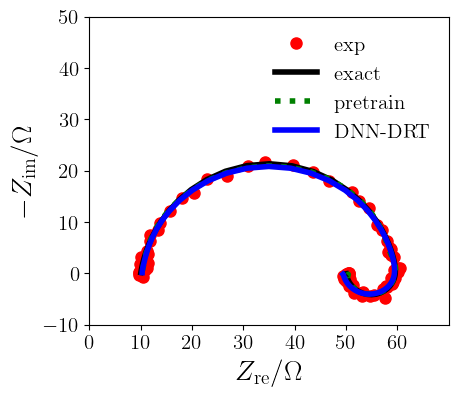

In [37]:
plt.plot(np.real(Z_exp), -np.imag(Z_exp), 'o', markersize=8, color='red', label='exp')
plt.plot(np.real(Z_exact), -np.imag(Z_exact), linewidth=4, color='black', label='exact')
plt.plot(np.real(Z_pretrain), -np.imag(Z_pretrain), linestyle=':', linewidth=4, color='green', label='pretrain')
plt.plot(np.real(Z_opt), -np.imag(Z_opt), linewidth=4, color='blue', label='DNN-DRT')

plt.axis([0,70,-10,50])
plt.xticks(np.arange(0, 70, step=10))
plt.legend(frameon=False, fontsize = 15, loc='upper right')
plt.gca().set_aspect('equal', adjustable='box')
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
fig = plt.gcf()
fig.set_size_inches(6.472, 4)
plt.show()